### Задание

Проведите полный цикл работы над вашим проектом, что проходили ранее. Pipeline выполнения задачи:

1. Загрузка и предобработка данных 

2. Описательный анализ данных, просмотр данных и вывод статистики

3. Постройте необходимые графики для анализа

4. Проверьте гипотезы (если потребуется)

5. Сделайте промежуточный отчет-вывод по исследованию

6. Определите, какую задачу вы будете решать (классификация, регрессия и т.д.)

7. Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

8. Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)

9. Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)

10. Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

### Рекомендации:

1. Соблюдайте PEP8

2. Комментируйте код в местах, где конструкция большая

3. Оставляйте промежуточные выводы по вашему исследованию и построению модели (так кураторам будет проще понять ваши заключения)

4. Экспериментируйте! Вы не ограничены в моделях и подходах. Можете использовать любые DS инструменты (и те, которые мы не разбирали с вами на курсе)

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [102]:
# Загрузка и вывод данных
df = pd.read_csv('gender_classification_v7.csv')
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


In [103]:
# Кодирование категориальных данных целевого столбца
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 312.7 KB


- В таблице 5001 запись
- Пропусков нет
- Все данные в числовом формате.

In [105]:
df.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.00000
mean,0.869626,13.181484,5.946311,0.493901,0.507898,0.493101,0.498900,0.49990
std,0.336748,1.107128,0.541268,0.500013,0.499988,0.500002,0.500049,0.50005
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,12.200000,5.500000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,13.100000,5.900000,0.000000,1.000000,0.000000,0.000000,0.00000
75%,1.000000,14.000000,6.400000,1.000000,1.000000,1.000000,1.000000,1.00000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000,1.00000


- Данные в таблице распределены равномерно, кроме столбца *'long_hair'*. Видно, что количество людей с длинными волосами составляет почти 87% исследуемых.
- Аномальных значений не наблюдается.
- Ширина лба варьируется в диапазоне [11.4, 15.5] см.
- Высота лба - в диапазоне [5.1, 7.1] см.

In [106]:
df.duplicated().sum()

1768

В таблице 1768 дубликатов

In [107]:
# Удаление дубликатов
df.drop_duplicates(inplace=True)

In [108]:
df.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
count,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000
mean,0.822456,13.217198,5.966038,0.536344,0.557686,0.538509,0.545314,0.551500
std,0.382188,1.115993,0.549789,0.498755,0.496738,0.498592,0.498019,0.497418
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.300000,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,13.200000,5.900000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,14.100000,6.400000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000,1.000000


После удаления дубликатов распределение незначительно сместилось.

array([[<Axes: title={'center': 'long_hair'}>,
        <Axes: title={'center': 'forehead_width_cm'}>,
        <Axes: title={'center': 'forehead_height_cm'}>],
       [<Axes: title={'center': 'nose_wide'}>,
        <Axes: title={'center': 'nose_long'}>,
        <Axes: title={'center': 'lips_thin'}>],
       [<Axes: title={'center': 'distance_nose_to_lip_long'}>,
        <Axes: title={'center': 'gender'}>, <Axes: >]], dtype=object)

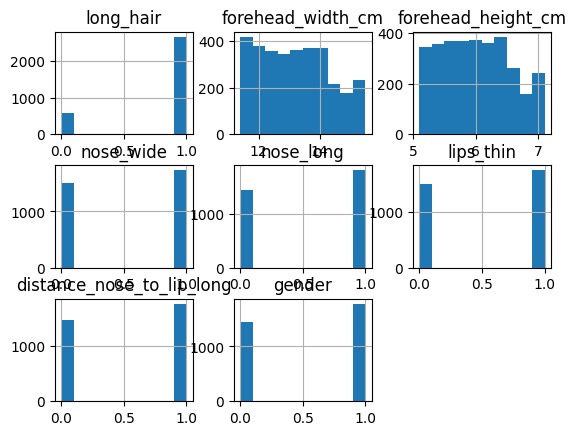

In [109]:
df.hist()

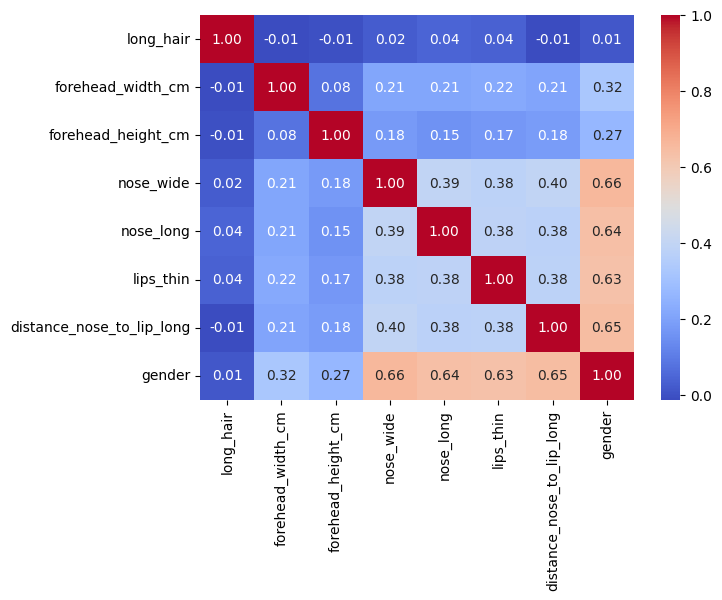

In [110]:
# Корреляционная матрица
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Из корреляционной матрицы видно, что:
- с целевой переменной хорошо коррелируют характеристики носа и губ (от 0.63 до 0.66)
- наименьшее влияние на целевую переменную оказывает длина волос (0.01)
- корреляции между признаками практически не наблюдается, незначительную зависимость между собой показывают также характеристики носа и губ (от 0.38 до 0.4)
Таким образом, форма носа и губ могут иметь значение для определения пола.

In [111]:
# отделение целевой переменной от признаков
X = df.drop('gender', axis=1)
y = df['gender']

In [112]:
y.value_counts(normalize=True)

gender
1    0.5515
0    0.4485
Name: proportion, dtype: float64

Классы плохо сбалансированы

In [113]:
# Получим веса классов для дальнейшего использования в модели
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights

array([1.11482759, 0.90661806])

In [114]:
# Разделение данных на тренировочную, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [115]:
# Масштабирование признаков
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

Т.к. целевой признак имеет 2 значения, будем решать задачу классификации.

Т.к. классы плохо сбалансированы, для оценки моделей будем использовать метрику ROC-AUC.

In [154]:
# Модель логистической регрессии
model_log_reg = LogisticRegression(class_weight='balanced', max_iter=200)
model_log_reg.fit(X_train, y_train)
roc_auc_score(y_val, model_log_reg.predict(X_val))

0.9629856641808833

In [117]:
# Модель логистической регрессии с использованием кросс-валидации
model_log_reg_cv = LogisticRegressionCV(solver='liblinear', random_state=12, class_weight='balanced', cv=5)
model_log_reg_cv.fit(X_train, y_train)
roc_auc_score(y_val, model_log_reg_cv.predict_proba(X_val)[:, 1])

0.9927299349610108

In [118]:
# Модель дерева решений
model_rf = DecisionTreeClassifier(class_weight='balanced')
model_rf.fit(X_train, y_train)
roc_auc_score(y_val, model_rf.predict(X_val))

0.9461810876153506

In [119]:
# Модель случайного леса с GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [4, 5, 6]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_rf = grid_search.best_estimator_
print(f'Лучшие параметры случайного леса: {grid_search.best_params_}')

# Оценка качества выбранной модели
print(f'ROC AUC для случайного леса: {roc_auc_score(y_val, best_rf.predict_proba(X_val)[:, 1])}')

Лучшие параметры случайного леса: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300}
ROC AUC для случайного леса: 0.993291790104539


In [141]:
# Модель полносвязной нейронной сети
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['auc'])
    
    return model

model_nn = create_model()

monitor = 'val_auc'
early_stopping = EarlyStopping(monitor=monitor, mode='max', patience=20, restore_best_weights=True)
save_best_weights = ModelCheckpoint(filepath='.weights.h5',
                                    save_weights_only=True,
                                    monitor=monitor,
                                    mode='max',
                                    save_best_only=True)

history = model_nn.fit(X_train, y_train.to_numpy(),
                    validation_data=(X_val, y_val.to_numpy()), 
                    epochs=100,
                    batch_size=64, 
                    class_weight={0:class_weights[0], 1:class_weights[1]},
                    callbacks=[early_stopping, save_best_weights])

print(f'ROC AUC на валидационной части: {model_nn.evaluate(X_val, y_val.to_numpy(), verbose=0)[1]}')

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7592 - loss: 0.5428 - val_auc: 0.9934 - val_loss: 0.2649
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9544 - loss: 0.2854 - val_auc: 0.9931 - val_loss: 0.1908
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9572 - loss: 0.2692 - val_auc: 0.9943 - val_loss: 0.1630
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9610 - loss: 0.2564 - val_auc: 0.9927 - val_loss: 0.1407
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9635 - loss: 0.2514 - val_auc: 0.9943 - val_loss: 0.1331
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9700 - loss: 0.2230 - val_auc: 0.9945 - val_loss: 0.1275
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9625 - loss: 0.2506 - val_auc: 0.9940 - val_loss: 0.1349
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9696 - loss: 0.2250 - val_auc: 0.9952 - val_loss: 0.1255
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9

Лучшая модель - полносвязная нейронная сеть

ROC-AUC на валидационной выборке здесь составил 0.9952327609062195

In [142]:
# Оценка на тестовой выборке
roc_auc_score(y_test, model_nn.predict(X_test))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


0.9926573785643378

Сравним полученные результаты с предсказанием простейшей dummy-модели на основе стратегии наиболее часто встречающегося класса из обучающей выборки.

In [152]:
# Создание и обучение модели
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

# Вычисление метрики ROC AUC
roc_auc_score(y_val, dummy_clf.predict_proba(X_val)[:, 1])

0.5

### Вывод:

В результате исследования были построены следующие модели с метрикой ROC-AUC на валидационной выборке:

| Модель | ROC-AUC |
|---|---|
| логистическая регрессия | 0.9629856641808833 |
| логистическая регрессия с использованием кросс-валидации | 0.9927299349610108|
| дерево решений | 0.9461810876153506 |
| случайный лес | 0.993291790104539 |
| полносвязная нейронная сеть | 0.9952327609062195 |


Как видно из таблицы, все модели продемонстрировали хорошую точность. Но наилучшей оказалась *модель полносвязной нейронной сети*.

ROC-AUC на валидационной выборке здесь составил 0.9952327609062195.

ROC-AUC на тестовой выборке составил 0.9926573785643378.

Сравнение созданных моделей с предсказаниями простой dummy-модели позволяет сделать вывод, что машинное обучение является более подходящим выбором, т.к. метрика ROC-AUC dummy-предсказания равно 0.5, а это сравнимо с ROC-AUC случайной модели.